In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import torchvision.models as models
import torch.nn as nn


from facenet_pytorch import InceptionResnetV1

In [2]:
# import os
# import numpy as np
# import shutil

# ANN_DIR = r"c:\Users\Hamza Asad\Desktop\University\Semester work\7th semester\DL\Dataset\annotations"
# BACKUP_DIR = os.path.join(ANN_DIR, "_backup")

# # Make backup directory if it doesn't exist
# os.makedirs(BACKUP_DIR, exist_ok=True)

# def fix_file(path, suffix):
#     try:
#         arr = np.load(path, allow_pickle=True)

#         # Convert based on file type
#         if suffix == "exp":  # classification label
#             value = int(float(arr))  # some may be strings
#             fixed = np.array(value, dtype=np.int64)

#         elif suffix in ["aro", "val"]:  # scalar regression
#             value = float(arr)
#             fixed = np.array(value, dtype=np.float32)

#         elif suffix == "lnd":  # landmarks
#             arr = np.array(arr, dtype=np.float32)
#             fixed = arr.reshape(-1)  # flatten if (68,2)

#         else:
#             return False, "Unknown suffix"

#         # Backup original
#         rel_name = os.path.basename(path)
#         shutil.copy2(path, os.path.join(BACKUP_DIR, rel_name))

#         # Save fixed
#         np.save(path, fixed)

#         return True, f"Fixed {suffix} → {fixed.shape if hasattr(fixed, 'shape') else fixed}"
#     except Exception as e:
#         return False, str(e)

# # Process all files
# issues = []
# for fname in os.listdir(ANN_DIR):
#     if not fname.endswith(".npy"):
#         continue

#     suffix = fname.split("_")[-1].replace(".npy", "")
#     path = os.path.join(ANN_DIR, fname)

#     ok, msg = fix_file(path, suffix)
#     if not ok:
#         issues.append((fname, msg))

# print("=== Fixing Done ===")
# print(f"Issues found: {len(issues)}")
# if issues:
#     print("First 10 issues:", issues[:10])


In [3]:
class Config:
    IMG_DIR = r"c:\Users\Hamza Asad\Desktop\University\Semester work\7th semester\DL\Dataset\images"
    ANN_DIR = r"c:\Users\Hamza Asad\Desktop\University\Semester work\7th semester\DL\Dataset\annotations"
    batch_size = 32
    num_epochs = 25
    lr = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
class AffectDataset(Dataset):
    def __init__(self, ids, img_dir, ann_dir, transform=None):
        self.ids = ids
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image = Image.open(os.path.join(self.img_dir, f"{img_id}.jpg")).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Force correct types
        exp = int(np.load(os.path.join(self.ann_dir, f"{img_id}_exp.npy")))
        aro = float(np.load(os.path.join(self.ann_dir, f"{img_id}_aro.npy")))
        val = float(np.load(os.path.join(self.ann_dir, f"{img_id}_val.npy")))

        # Return as tensors
        exp = torch.tensor(exp, dtype=torch.long)          # classification
        aro = torch.tensor(aro, dtype=torch.float32)       # regression
        val = torch.tensor(val, dtype=torch.float32)       # regression

        return image, {"exp": exp, "aro": aro, "val": val}


In [5]:
# ================================
# Collect valid IDs (only those with all annotations)
# ================================
img_ids = [int(os.path.splitext(f)[0]) for f in os.listdir(Config.IMG_DIR) if f.endswith(".jpg")]
img_ids.sort()

required_suffixes = ["aro", "exp", "lnd", "val"]

valid_ids = []
for img_id in img_ids:
    base = str(img_id)
    files_exist = all(os.path.exists(os.path.join(Config.ANN_DIR, f"{base}_{s}.npy")) for s in required_suffixes)
    if files_exist:
        valid_ids.append(img_id)

print(f"✅ Total usable samples: {len(valid_ids)} / {len(img_ids)}")

# ================================
# Train / Val / Test Split
# ================================
train_ids, test_ids = train_test_split(valid_ids, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42)

print(f"Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")

# ================================
# Transforms
# ================================
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ================================
# DataLoaders
# ================================
train_loader = DataLoader(
    AffectDataset(train_ids, Config.IMG_DIR, Config.ANN_DIR, transform=train_tf),
    batch_size=Config.batch_size, shuffle=True
)
val_loader = DataLoader(
    AffectDataset(val_ids, Config.IMG_DIR, Config.ANN_DIR, transform=val_tf),
    batch_size=Config.batch_size
)
test_loader = DataLoader(
    AffectDataset(test_ids, Config.IMG_DIR, Config.ANN_DIR, transform=val_tf),
    batch_size=Config.batch_size
)

print("✅ DataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


✅ Total usable samples: 3999 / 3999
Train: 2889 | Val: 510 | Test: 600
✅ DataLoaders ready:
  Train batches: 91
  Val batches: 16
  Test batches: 19


=== Dataset Diagnostics ===

Sample 1 - ID: 0
 Image size: 224x224
 Expression (exp): 0
 Arousal (aro): -0.078
 Valence (val): -0.177

Sample 2 - ID: 1
 Image size: 224x224
 Expression (exp): 0
 Arousal (aro): 0.184
 Valence (val): -0.368

Sample 3 - ID: 2
 Image size: 224x224
 Expression (exp): 4
 Arousal (aro): 0.532
 Valence (val): -0.063

Sample 4 - ID: 3
 Image size: 224x224
 Expression (exp): 0
 Arousal (aro): -0.005
 Valence (val): 0.005

Sample 5 - ID: 4
 Image size: 224x224
 Expression (exp): 2
 Arousal (aro): -0.508
 Valence (val): -0.643

=== Image Size Stats ===
 Min: 224x224
 Max: 224x224
 Mean: 224.0x224.0

=== Expression Distribution ===
 Class 0: 500 samples
 Class 1: 500 samples
 Class 2: 500 samples
 Class 3: 500 samples
 Class 4: 500 samples
 Class 5: 500 samples
 Class 6: 500 samples
 Class 7: 499 samples

=== Arousal Stats ===
 Min: -0.667, Max: 0.984, Mean: 0.354, Std: 0.379
=== Valence Stats ===
 Min: -0.987, Max: 0.982, Mean: -0.192, Std: 0.466


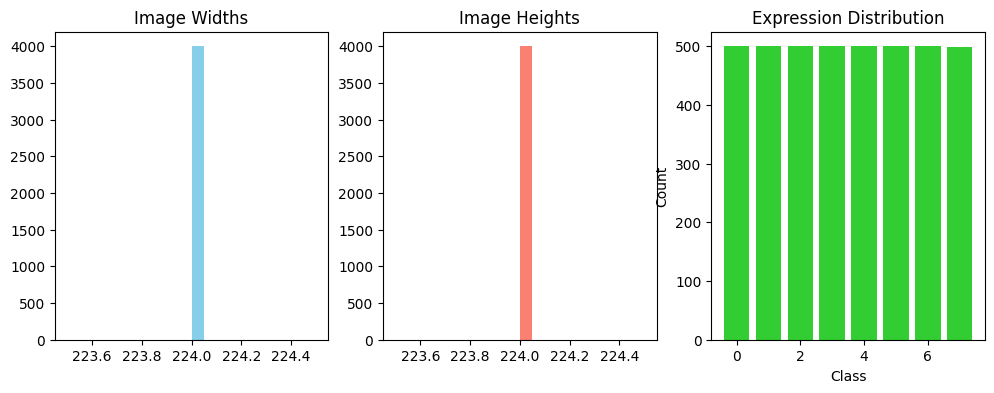

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

# Paths
IMG_DIR = Config.IMG_DIR
ANN_DIR = Config.ANN_DIR

def dataset_diagnostics(img_ids, ann_dir, num_samples=5):
    widths, heights = [], []
    exps, aros, vals = [], [], []

    print("=== Dataset Diagnostics ===")
    for i, img_id in enumerate(img_ids):
        # Image stats
        img_path = os.path.join(IMG_DIR, f"{img_id}.jpg")
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

        # Labels
        exp = int(np.load(os.path.join(ann_dir, f"{img_id}_exp.npy")))
        aro = float(np.load(os.path.join(ann_dir, f"{img_id}_aro.npy")))
        val = float(np.load(os.path.join(ann_dir, f"{img_id}_val.npy")))
        exps.append(exp)
        aros.append(aro)
        vals.append(val)

        if i < num_samples:  # show a few examples
            print(f"\nSample {i+1} - ID: {img_id}")
            print(f" Image size: {w}x{h}")
            print(f" Expression (exp): {exp}")
            print(f" Arousal (aro): {aro:.3f}")
            print(f" Valence (val): {val:.3f}")

    # Image dimension stats
    print("\n=== Image Size Stats ===")
    print(f" Min: {min(widths)}x{min(heights)}")
    print(f" Max: {max(widths)}x{max(heights)}")
    print(f" Mean: {np.mean(widths):.1f}x{np.mean(heights):.1f}")

    # Expression distribution
    exp_counts = Counter(exps)
    print("\n=== Expression Distribution ===")
    for k, v in sorted(exp_counts.items()):
        print(f" Class {k}: {v} samples")

    # Arousal & Valence stats
    print("\n=== Arousal Stats ===")
    print(f" Min: {np.min(aros):.3f}, Max: {np.max(aros):.3f}, Mean: {np.mean(aros):.3f}, Std: {np.std(aros):.3f}")
    print("=== Valence Stats ===")
    print(f" Min: {np.min(vals):.3f}, Max: {np.max(vals):.3f}, Mean: {np.mean(vals):.3f}, Std: {np.std(vals):.3f}")

    # Plots
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.hist(widths, bins=20, color="skyblue")
    plt.title("Image Widths")

    plt.subplot(1,3,2)
    plt.hist(heights, bins=20, color="salmon")
    plt.title("Image Heights")

    plt.subplot(1,3,3)
    plt.bar(exp_counts.keys(), exp_counts.values(), color="limegreen")
    plt.title("Expression Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Run diagnostics
dataset_diagnostics(valid_ids, ANN_DIR, num_samples=5)


=== Pixel Intensity Stats (0–255 range) ===
 Min: 0.0
 Max: 255.0
 Mean: 119.49
 Std: 61.77


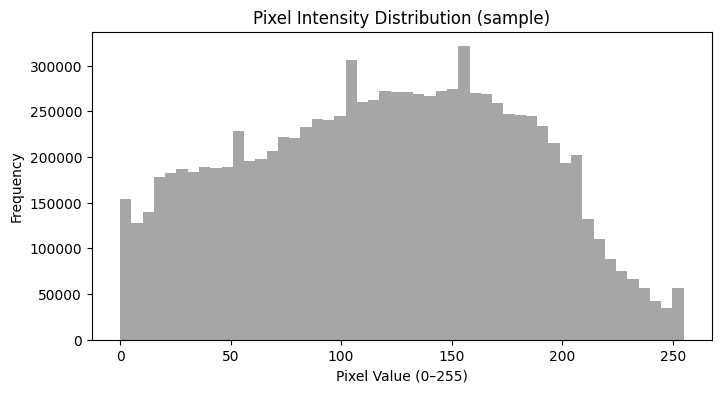

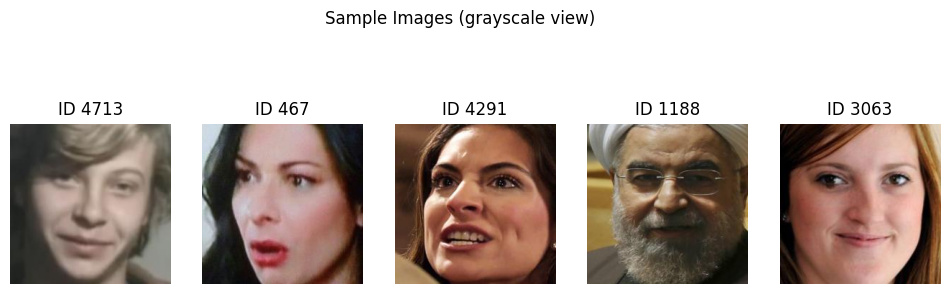

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

def pixel_intensity_analysis(img_ids, img_dir, sample_size=200):
    # Take a random subset (for speed)
    sample_ids = random.sample(img_ids, min(sample_size, len(img_ids)))
    intensities = []

    for img_id in sample_ids:
        img_path = os.path.join(img_dir, f"{img_id}.jpg")
        with Image.open(img_path) as img:
            img = img.convert("L")  # grayscale for intensity check
            arr = np.array(img, dtype=np.float32).flatten()
            intensities.extend(arr)

    intensities = np.array(intensities)

    print("=== Pixel Intensity Stats (0–255 range) ===")
    print(f" Min: {np.min(intensities):.1f}")
    print(f" Max: {np.max(intensities):.1f}")
    print(f" Mean: {np.mean(intensities):.2f}")
    print(f" Std: {np.std(intensities):.2f}")

    # Plot histogram
    plt.figure(figsize=(8,4))
    plt.hist(intensities, bins=50, color="gray", alpha=0.7)
    plt.title("Pixel Intensity Distribution (sample)")
    plt.xlabel("Pixel Value (0–255)")
    plt.ylabel("Frequency")
    plt.show()

    # Show a few sample images side by side
    plt.figure(figsize=(12,4))
    for i, img_id in enumerate(sample_ids[:5]):
        img_path = os.path.join(img_dir, f"{img_id}.jpg")
        with Image.open(img_path) as img:
            plt.subplot(1,5,i+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(f"ID {img_id}")
    plt.suptitle("Sample Images (grayscale view)")
    plt.show()

# Run pixel intensity check
pixel_intensity_analysis(valid_ids, Config.IMG_DIR, sample_size=200)


In [7]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone="resnet"):
        super().__init__()
        if backbone == "resnet":
            base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # ✅ pretrained
            in_features = base.fc.in_features
            base.fc = nn.Identity()  # remove last fc
            self.backbone = base

        # elif backbone == "efficientnet":
        #     base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        #     in_features = base.classifier[1].in_features
        #     base.classifier = nn.Identity()
        #     self.backbone = base

        elif backbone == "vggface2":
            # Pretrained on VGGFace2 (facenet-pytorch InceptionResnetV1)
            base = InceptionResnetV1(pretrained='vggface2',classify=False)
            # in_features = base.last_linear.in_features
            # base.last_linear = nn.Identity()   # remove final FC
            # base.logits = nn.Identity()
            in_features = 512  # InceptionResnetV1 outputs 512-dim features
            self.backbone = base


        # Multi-task heads
        self.exp_head = nn.Linear(in_features, 8)      # 8 emotion classes
        self.reg_head = nn.Linear(in_features, 2)      # arousal + valence

    def forward(self, x):
        feats = self.backbone(x)
        # if isinstance(feats, tuple):  # for InceptionResnetV1 which returns (features, aux)
        #     feats = feats[0]
        exp_logits = self.exp_head(feats)
        reg_outputs = self.reg_head(feats)
        return exp_logits, reg_outputs


# freeze/unfreeze helper
def freeze_backbone(model, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

# ---------- Regression Metrics ----------
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

def sagr(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def ccc(y_true, y_pred):
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    var_true, var_pred = np.var(y_true), np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2)

# ---------- Trainer ----------
class Trainer:
    def __init__(self, model, train_loader, val_loader, config, name="model"):
        self.model = model.to(config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.name = name

        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        print("🔒 Backbone frozen. Training heads only.")

        self.optimizer = torch.optim.Adam([
            {"params": self.model.backbone.parameters(), "lr": config.lr * 0.1},   # fine-tune slowly
            {"params": self.model.exp_head.parameters(), "lr": config.lr},        # train heads faster
            {"params": self.model.reg_head.parameters(), "lr": config.lr}
        ], lr=config.lr)

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", patience=3, factor=0.5)
        
        # Tracking
        self.history = {"train_loss": [], "val_loss": [],
                        "train_acc": [], "val_acc": []}
        self.best_val_loss = float("inf")
        self.patience_counter = 0

    def train(self, early_stopping_patience=5):

        for epoch in range(self.config.num_epochs):
            if epoch == 5:
                print("🔓 Unfreezing backbone for fine-tuning...")
                for param in self.model.backbone.parameters():
                    param.requires_grad = True
                self.optimizer = torch.optim.Adam([
                    {"params": self.model.backbone.parameters(), "lr": self.config.lr * 0.01},
                    {"params": self.model.exp_head.parameters(), "lr": self.config.lr},
                    {"params": self.model.reg_head.parameters(), "lr": self.config.lr}
                ], lr=self.config.lr)

            # ---------------- TRAIN ----------------
            self.model.train()
            total_loss, correct, total = 0, 0, 0

            pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs} [Train]", leave=False)
            for images, targets in pbar:
                images = images.to(self.config.device)
                exp = targets["exp"].to(self.config.device)
                aro = targets["aro"].to(self.config.device)
                val = targets["val"].to(self.config.device)

                exp_logits, reg_outputs = self.model(images)
                reg_targets = torch.stack([aro, val], dim=1)

                loss = self.ce_loss(exp_logits, exp) + self.mse_loss(reg_outputs, reg_targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                preds = exp_logits.argmax(1)
                correct += (preds == exp).sum().item()
                total += exp.size(0)

            train_loss = total_loss / len(self.train_loader)
            train_acc = correct / total

            # ---------------- VALIDATE ----------------
            val_loss, val_acc = self.validate()

            # Logging
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_acc"].append(val_acc)

            # Scheduler
            self.scheduler.step(val_loss)

            # Save checkpoint every epoch
            torch.save(self.model.state_dict(), f"{self.name}_epoch{epoch+1}.pth")

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), f"{self.name}_best.pth")
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            # Epoch summary
            print(f"Epoch {epoch+1}/{self.config.num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Early stopping
            if self.patience_counter >= early_stopping_patience:
                print("⏹️ Early stopping triggered")
                break

                
    def validate(self):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, targets in self.val_loader:
                images = images.to(self.config.device)
                exp = targets["exp"].to(self.config.device)
                aro = targets["aro"].to(self.config.device)
                val = targets["val"].to(self.config.device)

                exp_logits, reg_outputs = self.model(images)
                reg_targets = torch.stack([aro, val], dim=1)

                loss = self.ce_loss(exp_logits, exp) + self.mse_loss(reg_outputs, reg_targets)
                val_loss += loss.item()

                preds = exp_logits.argmax(1)
                correct += (preds == exp).sum().item()
                total += exp.size(0)

        val_loss /= len(self.val_loader)
        val_acc = correct / total
        return val_loss, val_acc

    def evaluate(self, test_loader):
        self.model.eval()
        all_exp, all_preds = [], []
        all_aro, all_val = [], []
        all_aro_pred, all_val_pred = [], []

        with torch.no_grad():
            for images, targets in tqdm(test_loader, desc="Evaluating"):
                images = images.to(self.config.device)
                exp = targets["exp"].cpu().numpy()
                aro = targets["aro"].cpu().numpy()
                val = targets["val"].cpu().numpy()

                exp_logits, reg_outputs = self.model(images)
                preds = exp_logits.argmax(1).cpu().numpy()
                reg_outputs = reg_outputs.cpu().numpy()

                all_exp.extend(exp)
                all_preds.extend(preds)
                all_aro.extend(aro)
                all_val.extend(val)
                all_aro_pred.extend(reg_outputs[:, 0])
                all_val_pred.extend(reg_outputs[:, 1])

        # Classification metrics
        acc = accuracy_score(all_exp, all_preds)
        f1 = f1_score(all_exp, all_preds, average="weighted")

        # Regression metrics
        aro_rmse = rmse(np.array(all_aro), np.array(all_aro_pred))
        val_rmse = rmse(np.array(all_val), np.array(all_val_pred))
        aro_corr = corr(np.array(all_aro), np.array(all_aro_pred))
        val_corr = corr(np.array(all_val), np.array(all_val_pred))
        aro_sagr = sagr(np.array(all_aro), np.array(all_aro_pred))
        val_sagr = sagr(np.array(all_val), np.array(all_val_pred))
        aro_ccc = ccc(np.array(all_aro), np.array(all_aro_pred))
        val_ccc = ccc(np.array(all_val), np.array(all_val_pred))

        print("\n=== Test Evaluation ===")
        print(f"Classification - Acc: {acc:.4f}, F1: {f1:.4f}")
        print(f"Arousal - RMSE: {aro_rmse:.4f}, CORR: {aro_corr:.4f}, SAGR: {aro_sagr:.4f}, CCC: {aro_ccc:.4f}")
        print(f"Valence - RMSE: {val_rmse:.4f}, CORR: {val_corr:.4f}, SAGR: {val_sagr:.4f}, CCC: {val_ccc:.4f}")


# **MODELs RUN**

- **resnet**

In [25]:
print("Training ResNet (fine-tuned)...")
resnet_model = MultiTaskModel("resnet")
trainer_resnet = Trainer(resnet_model, train_loader, val_loader, Config, name="resnet")
trainer_resnet.train()

print("Evaluating best ResNet...")
trainer_resnet.model.load_state_dict(torch.load("resnet_best.pth"))
trainer_resnet.evaluate(test_loader)


Training ResNet (fine-tuned)...


Epoch 1/25 | Train Loss: 2.0699 | Train Acc: 0.2987 || Val Loss: 1.8917 | Val Acc: 0.3529


Epoch 2/25 | Train Loss: 1.5580 | Train Acc: 0.4846 || Val Loss: 1.7936 | Val Acc: 0.3843


Epoch 3/25 | Train Loss: 1.3186 | Train Acc: 0.5652 || Val Loss: 1.7887 | Val Acc: 0.3725


Epoch 4/25 | Train Loss: 1.0616 | Train Acc: 0.6604 || Val Loss: 1.8559 | Val Acc: 0.3804


Epoch 5/25 | Train Loss: 0.8624 | Train Acc: 0.7373 || Val Loss: 2.2260 | Val Acc: 0.3804


Epoch 6/25 | Train Loss: 0.7040 | Train Acc: 0.7899 || Val Loss: 2.2360 | Val Acc: 0.3941


Epoch 7/25 | Train Loss: 0.5986 | Train Acc: 0.8342 || Val Loss: 2.3141 | Val Acc: 0.3882


Epoch 8/25 | Train Loss: 0.3778 | Train Acc: 0.8996 || Val Loss: 2.2057 | Val Acc: 0.4020
⏹️ Early stopping triggered
Evaluating best ResNet...


Evaluating: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


=== Test Evaluation ===
Classification - Acc: 0.4433, F1: 0.4399
Arousal - RMSE: 0.3835, CORR: 0.4071, SAGR: 0.7667, CCC: 0.3555
Valence - RMSE: 0.4391, CORR: 0.4317, SAGR: 0.7150, CCC: 0.3528


- **VGGFACE2NET**

In [18]:
print("Training VGGFace2Net (fine-tuned on affect)...")
vggface2_model = MultiTaskModel("vggface2")
trainer_vggface2 = Trainer(vggface2_model, train_loader, val_loader, Config, name="vggface2")
trainer_vggface2.train()

print("Evaluating best VGGFace2Net...")
trainer_vggface2.model.load_state_dict(torch.load("vggface2_best.pth"))
trainer_vggface2.evaluate(test_loader)


Training VGGFace2Net (fine-tuned on affect)...
🔒 Backbone frozen. Training heads only.


Epoch 1/25 | Train Loss: 2.2901 | Train Acc: 0.2170 || Val Loss: 2.2503 | Val Acc: 0.2373


Epoch 2/25 | Train Loss: 2.2032 | Train Acc: 0.2915 || Val Loss: 2.1907 | Val Acc: 0.2333


Epoch 3/25 | Train Loss: 2.1453 | Train Acc: 0.3043 || Val Loss: 2.1553 | Val Acc: 0.2471


Epoch 4/25 | Train Loss: 2.1043 | Train Acc: 0.3115 || Val Loss: 2.1278 | Val Acc: 0.2412


Epoch 5/25 | Train Loss: 2.0774 | Train Acc: 0.3164 || Val Loss: 2.1081 | Val Acc: 0.2471
🔓 Unfreezing backbone for fine-tuning...


Epoch 6/25 | Train Loss: 1.9067 | Train Acc: 0.3818 || Val Loss: 1.8416 | Val Acc: 0.3804


Epoch 7/25 | Train Loss: 1.6342 | Train Acc: 0.4766 || Val Loss: 1.6601 | Val Acc: 0.4275


Epoch 8/25 | Train Loss: 1.4379 | Train Acc: 0.5261 || Val Loss: 1.5920 | Val Acc: 0.4196


Epoch 9/25 | Train Loss: 1.2793 | Train Acc: 0.5801 || Val Loss: 1.5643 | Val Acc: 0.4431


Epoch 10/25 | Train Loss: 1.1310 | Train Acc: 0.6386 || Val Loss: 1.5916 | Val Acc: 0.4333


Epoch 11/25 | Train Loss: 0.9793 | Train Acc: 0.6968 || Val Loss: 1.6034 | Val Acc: 0.4412


Epoch 12/25 | Train Loss: 0.8534 | Train Acc: 0.7390 || Val Loss: 1.6598 | Val Acc: 0.4353


Epoch 13/25 | Train Loss: 0.7187 | Train Acc: 0.7906 || Val Loss: 1.7219 | Val Acc: 0.4510


Epoch 14/25 | Train Loss: 0.5859 | Train Acc: 0.8539 || Val Loss: 1.8240 | Val Acc: 0.4451
⏹️ Early stopping triggered
Evaluating best VGGFace2Net...


Evaluating: 100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


=== Test Evaluation ===
Classification - Acc: 0.5217, F1: 0.5225
Arousal - RMSE: 0.3342, CORR: 0.5194, SAGR: 0.7850, CCC: 0.4410
Valence - RMSE: 0.3814, CORR: 0.5889, SAGR: 0.7583, CCC: 0.5129


In [56]:
# Recreate trainer for VGGFace2 just to access history
vgg_model = MultiTaskModel("vggface2").to(Config.device)
vgg_model.load_state_dict(torch.load("vggface2_best.pth", map_location=Config.device))

trainer_vgg = Trainer(vgg_model, train_loader, val_loader, Config, name="vggface2")

# If you have saved history from previous training, load it
# trainer_vgg.history = <load from pickle or previously saved dict>


🔒 Backbone frozen. Training heads only.


# **Metrics eval**

In [9]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import krippendorff


 - **VGNET**

In [10]:

# === Concordance Correlation Coefficient ===
def concordance_ccc(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    var_true, var_pred = np.var(y_true), np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)
    return ccc

# ===== Reload best model checkpoint =====
best_model = MultiTaskModel(backbone="vggface2").to(Config.device)
best_model.load_state_dict(torch.load("vggface2_best.pth", map_location=Config.device))
best_model.eval()

# ===== Extended Evaluation =====
def extended_evaluate(model, dataloader):
    all_labels, all_preds, all_probs = [], [], []
    all_reg_targets, all_reg_preds = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(Config.device)
            exp = targets["exp"].to(Config.device)
            aro = targets["aro"].to(Config.device)
            val = targets["val"].to(Config.device)

            exp_logits, reg_outputs = model(images)
            probs = torch.softmax(exp_logits, dim=1)
            preds = exp_logits.argmax(dim=1)

            all_labels.extend(exp.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            reg_targets = torch.stack([aro, val], dim=1)
            all_reg_targets.extend(reg_targets.cpu().numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())

    # Classification metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    kappa = cohen_kappa_score(all_labels, all_preds)

    # Binarize labels for AUC/PR
    y_true_bin = label_binarize(all_labels, classes=list(range(8)))
    try:
        auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
        pr_auc = average_precision_score(y_true_bin, all_probs, average="macro")
    except:
        auc, pr_auc = None, None

    # Krippendorff’s Alpha
    alpha = krippendorff.alpha(reliability_data=[all_labels, all_preds], level_of_measurement="nominal")

    # Regression metrics
    all_reg_targets = np.array(all_reg_targets)
    all_reg_preds = np.array(all_reg_preds)

    results = {
        "Accuracy": acc,
        "F1": f1,
        "Kappa": kappa,
        "Alpha": alpha,
        "AUC": auc,
        "PR-AUC": pr_auc,
        "Arousal_RMSE": np.sqrt(np.mean((all_reg_targets[:,0] - all_reg_preds[:,0])**2)),
        "Arousal_CORR": np.corrcoef(all_reg_targets[:,0], all_reg_preds[:,0])[0,1],
        "Arousal_SAGR": np.mean(np.sign(all_reg_targets[:,0]) == np.sign(all_reg_preds[:,0])),
        "Arousal_CCC": concordance_ccc(all_reg_targets[:,0], all_reg_preds[:,0]),
        "Valence_RMSE": np.sqrt(np.mean((all_reg_targets[:,1] - all_reg_preds[:,1])**2)),
        "Valence_CORR": np.corrcoef(all_reg_targets[:,1], all_reg_preds[:,1])[0,1],
        "Valence_SAGR": np.mean(np.sign(all_reg_targets[:,1]) == np.sign(all_reg_preds[:,1])),
        "Valence_CCC": concordance_ccc(all_reg_targets[:,1], all_reg_preds[:,1]),
    }

    return results



# ===== Run evaluation on test set =====
extended_results = extended_evaluate(best_model, test_loader)

print("\n=== Extended Test Evaluation ===")
for k, v in extended_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) and v is not None else f"{k}: {v}")



=== Extended Test Evaluation ===
Accuracy: 0.5217
F1: 0.5225
Kappa: 0.4521
Alpha: 0.4525
AUC: 0.8630
PR-AUC: 0.5208
Arousal_RMSE: 0.3341790735721588
Arousal_CORR: 0.5194
Arousal_SAGR: 0.7850
Arousal_CCC: 0.4410
Valence_RMSE: 0.38136157393455505
Valence_CORR: 0.5889
Valence_SAGR: 0.7583
Valence_CCC: 0.5129


- **RESNET**

In [11]:
# ===== Load trained ResNet model =====
resnet_model = MultiTaskModel("resnet").to(Config.device)
resnet_model.load_state_dict(torch.load("pre_modelfiles/resnet_best.pth", map_location=Config.device))
resnet_model.eval()

# ===== Evaluate using Trainer =====
trainer_resnet = Trainer(resnet_model, train_loader=None, val_loader=None, config=Config, name="resnet")
print("Evaluating best ResNet...")
trainer_resnet.evaluate(test_loader)

# ===== Optional: Extended metrics =====
resnet_extended_results = extended_evaluate(resnet_model, test_loader)
print("\n=== Extended Test Evaluation for ResNet ===")
for k, v in resnet_extended_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) and v is not None else f"{k}: {v}")


🔒 Backbone frozen. Training heads only.
Evaluating best ResNet...


Evaluating: 100%|██████████| 19/19 [00:22<00:00,  1.16s/it]



=== Test Evaluation ===
Classification - Acc: 0.4433, F1: 0.4399
Arousal - RMSE: 0.3835, CORR: 0.4071, SAGR: 0.7667, CCC: 0.3555
Valence - RMSE: 0.4391, CORR: 0.4317, SAGR: 0.7150, CCC: 0.3528

=== Extended Test Evaluation for ResNet ===
Accuracy: 0.4433
F1: 0.4399
Kappa: 0.3626
Alpha: 0.3598
AUC: 0.8256
PR-AUC: 0.4564
Arousal_RMSE: 0.3835211396217346
Arousal_CORR: 0.4071
Arousal_SAGR: 0.7667
Arousal_CCC: 0.3555
Valence_RMSE: 0.4391232132911682
Valence_CORR: 0.4317
Valence_SAGR: 0.7150
Valence_CCC: 0.3528


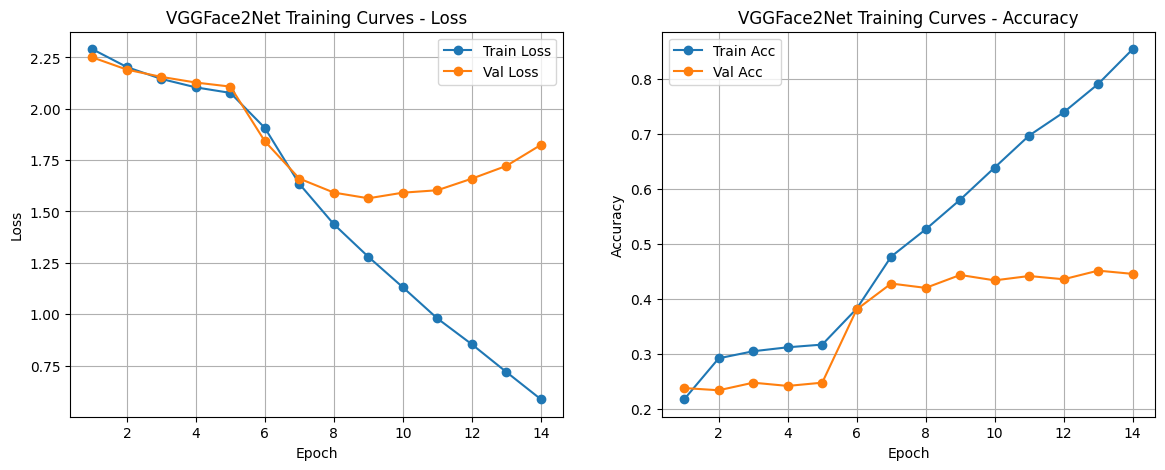

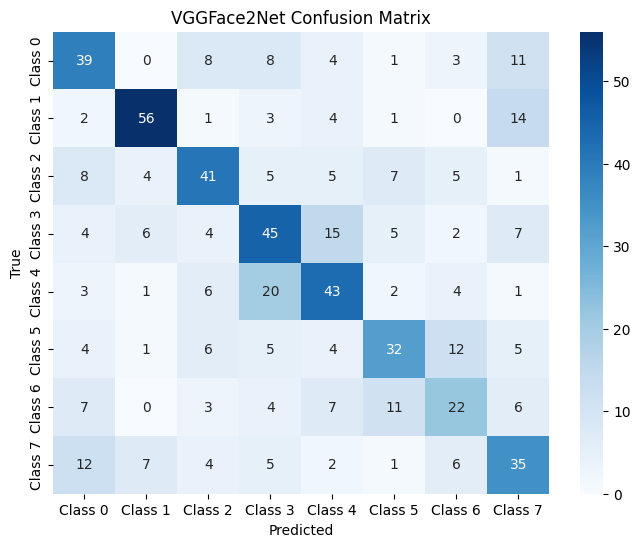

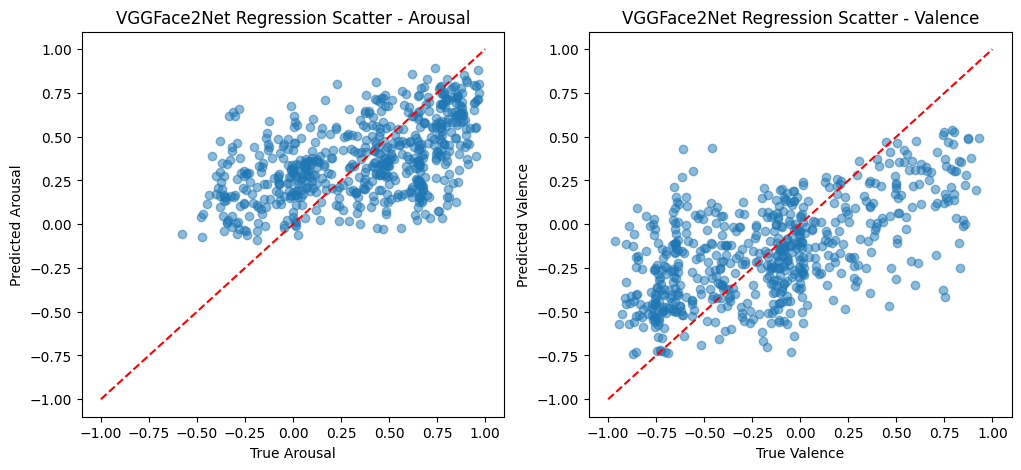

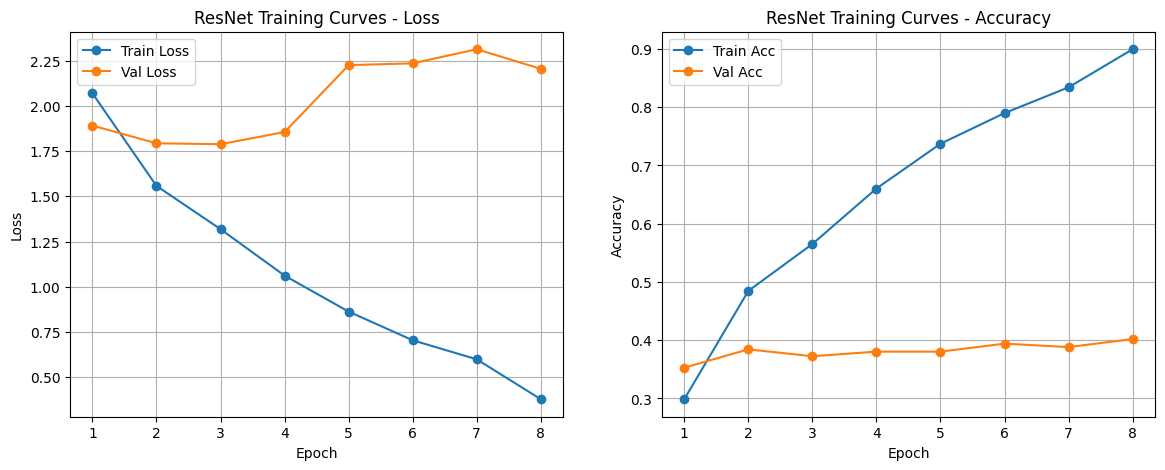

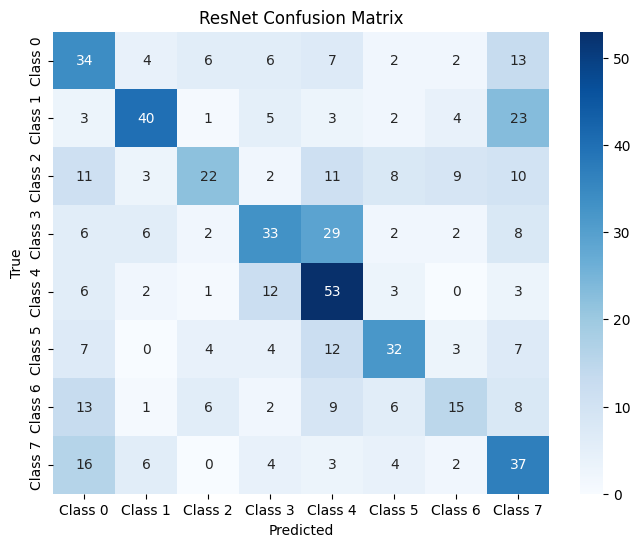

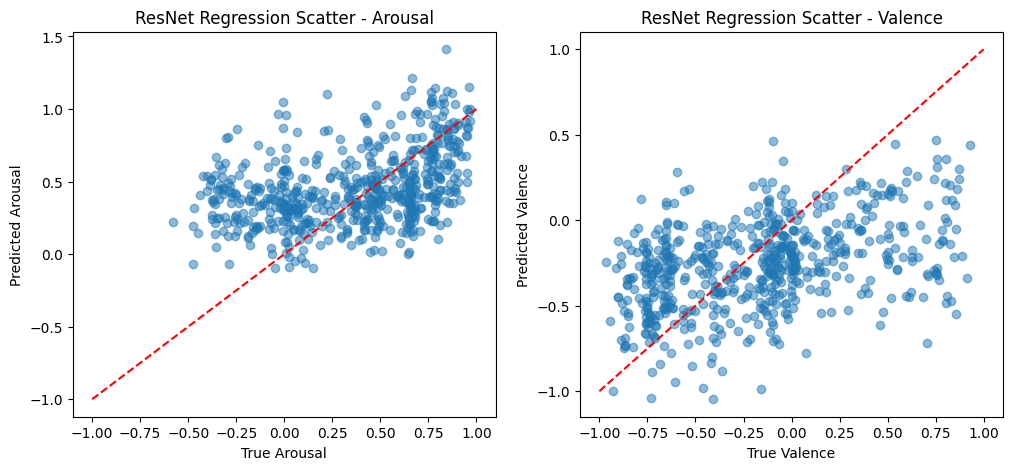

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

# ===== Epoch data (from your training logs) =====
# VGGFace2Net
vgg_train_loss = [2.2901, 2.2032, 2.1453, 2.1043, 2.0774, 1.9067, 1.6342, 1.4379, 1.2793, 1.1310, 0.9793, 0.8534, 0.7187, 0.5859]
vgg_val_loss   = [2.2503, 2.1907, 2.1553, 2.1278, 2.1081, 1.8416, 1.6601, 1.5920, 1.5643, 1.5916, 1.6034, 1.6598, 1.7219, 1.8240]
vgg_train_acc  = [0.2170, 0.2915, 0.3043, 0.3115, 0.3164, 0.3818, 0.4766, 0.5261, 0.5801, 0.6386, 0.6968, 0.7390, 0.7906, 0.8539]
vgg_val_acc    = [0.2373, 0.2333, 0.2471, 0.2412, 0.2471, 0.3804, 0.4275, 0.4196, 0.4431, 0.4333, 0.4412, 0.4353, 0.4510, 0.4451]

# ResNet
res_train_loss = [2.0699, 1.5580, 1.3186, 1.0616, 0.8624, 0.7040, 0.5986, 0.3778]
res_val_loss   = [1.8917, 1.7936, 1.7887, 1.8559, 2.2260, 2.2360, 2.3141, 2.2057]
res_train_acc  = [0.2987, 0.4846, 0.5652, 0.6604, 0.7373, 0.7899, 0.8342, 0.8996]
res_val_acc    = [0.3529, 0.3843, 0.3725, 0.3804, 0.3804, 0.3941, 0.3882, 0.4020]

# ===== Training Curves =====
def plot_training_curves(train_loss, val_loss, train_acc, val_acc, title):
    epochs = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(14,5))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, '-o', label="Train Loss")
    plt.plot(epochs, val_loss, '-o', label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, '-o', label="Train Acc")
    plt.plot(epochs, val_acc, '-o', label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()

# ===== Confusion Matrix =====
def plot_confusion(model, dataloader, classes, title="Confusion Matrix"):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(Config.device)
            exp = targets["exp"].to(Config.device)
            exp_logits, _ = model(images)
            preds = exp_logits.argmax(dim=1)
            all_labels.extend(exp.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# ===== Regression Scatter =====
def plot_regression_scatter(model, dataloader, title="Regression Scatter"):
    model.eval()
    true_aro, true_val, pred_aro, pred_val = [], [], [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(Config.device)
            aro = targets["aro"].cpu().numpy()
            val = targets["val"].cpu().numpy()

            _, reg_outputs = model(images)
            reg_outputs = reg_outputs.cpu().numpy()

            true_aro.extend(aro)
            true_val.extend(val)
            pred_aro.extend(reg_outputs[:,0])
            pred_val.extend(reg_outputs[:,1])

    plt.figure(figsize=(12,5))
    # Arousal
    plt.subplot(1,2,1)
    plt.scatter(true_aro, pred_aro, alpha=0.5)
    plt.plot([-1,1], [-1,1], 'r--')
    plt.xlabel("True Arousal")
    plt.ylabel("Predicted Arousal")
    plt.title(f"{title} - Arousal")

    # Valence
    plt.subplot(1,2,2)
    plt.scatter(true_val, pred_val, alpha=0.5)
    plt.plot([-1,1], [-1,1], 'r--')
    plt.xlabel("True Valence")
    plt.ylabel("Predicted Valence")
    plt.title(f"{title} - Valence")

    plt.show()

# ===== Classes =====
classes = [f"Class {i}" for i in range(8)]

# ===== Plot everything =====
# VGGFace2Net
plot_training_curves(vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc, "VGGFace2Net Training Curves")
plot_confusion(best_model, test_loader, classes, title="VGGFace2Net Confusion Matrix")
plot_regression_scatter(best_model, test_loader, title="VGGFace2Net Regression Scatter")

# ResNet
plot_training_curves(res_train_loss, res_val_loss, res_train_acc, res_val_acc, "ResNet Training Curves")
plot_confusion(resnet_model, test_loader, classes, title="ResNet Confusion Matrix")
plot_regression_scatter(resnet_model, test_loader, title="ResNet Regression Scatter")


# **Check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

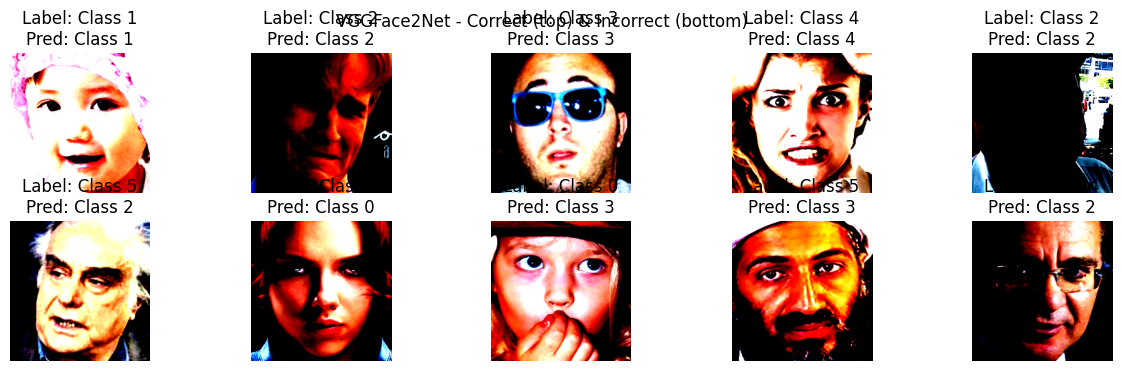

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

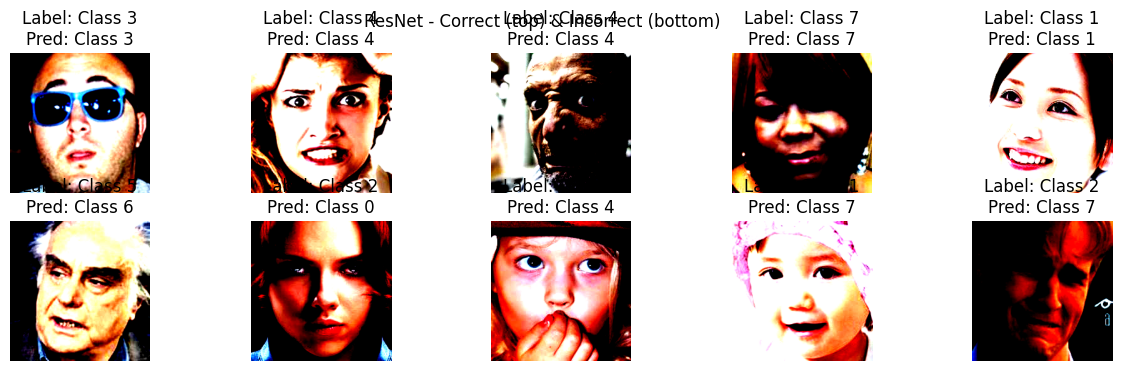

In [14]:
import matplotlib.pyplot as plt
import torch

# -------- Define expression classes --------
classes = [f"Class {i}" for i in range(8)]  # Replace with actual emotion names if available
# Example: classes = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral", "Other"]

# -------- Visualization Function --------
def visualize_classifications(model, dataloader, classes, num_samples=5, model_name="Model"):
    model.eval()
    correct_images, correct_labels, correct_preds = [], [], []
    incorrect_images, incorrect_labels, incorrect_preds = [], [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(Config.device)
            labels = targets["exp"].to(Config.device)

            logits, _ = model(images)
            preds = logits.argmax(dim=1)

            for img, label, pred in zip(images.cpu(), labels.cpu(), preds.cpu()):
                if label == pred:
                    if len(correct_images) < num_samples:
                        correct_images.append(img)
                        correct_labels.append(label)
                        correct_preds.append(pred)
                else:
                    if len(incorrect_images) < num_samples:
                        incorrect_images.append(img)
                        incorrect_labels.append(label)
                        incorrect_preds.append(pred)

            if len(correct_images) >= num_samples and len(incorrect_images) >= num_samples:
                break

    # Plot correctly classified
    plt.figure(figsize=(15, 4))
    for i, img in enumerate(correct_images):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img.permute(1,2,0).numpy())
        plt.title(f"Label: {classes[correct_labels[i]]}\nPred: {classes[correct_preds[i]]}")
        plt.axis('off')

    # Plot incorrectly classified
    for i, img in enumerate(incorrect_images):
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img.permute(1,2,0).numpy())
        plt.title(f"Label: {classes[incorrect_labels[i]]}\nPred: {classes[incorrect_preds[i]]}")
        plt.axis('off')

    plt.suptitle(f"{model_name} - Correct (top) & Incorrect (bottom)")
    plt.show()


# -------- Visualize for both models --------
visualize_classifications(best_model, test_loader, classes, num_samples=5, model_name="VGGFace2Net")
visualize_classifications(resnet_model, test_loader, classes, num_samples=5, model_name="ResNet")


# **extra**

**efficientnet**

In [26]:
print("\nTraining EfficientNet (fine-tuned)...")
effnet_model = MultiTaskModel("efficientnet")
trainer_effnet = Trainer(effnet_model, train_loader, val_loader, Config, name="efficientnet")
trainer_effnet.train()

print("\nEvaluating best EfficientNet...")
trainer_effnet.model.load_state_dict(torch.load("efficientnet_best.pth"))
trainer_effnet.evaluate(test_loader)



Training EfficientNet (fine-tuned)...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Hamza Asad/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:33<00:00, 631kB/s] 


Epoch 1/25 | Train Loss: 2.1233 | Train Acc: 0.2485 || Val Loss: 2.0140 | Val Acc: 0.2706


Epoch 2/25 | Train Loss: 1.7346 | Train Acc: 0.4095 || Val Loss: 1.8643 | Val Acc: 0.3275


Epoch 3/25 | Train Loss: 1.5101 | Train Acc: 0.4839 || Val Loss: 1.8425 | Val Acc: 0.3608


Epoch 4/25 | Train Loss: 1.3127 | Train Acc: 0.5666 || Val Loss: 1.8391 | Val Acc: 0.3627


Epoch 5/25 | Train Loss: 1.0989 | Train Acc: 0.6611 || Val Loss: 1.9252 | Val Acc: 0.3843


Epoch 6/25 | Train Loss: 0.9366 | Train Acc: 0.7127 || Val Loss: 2.0064 | Val Acc: 0.3824


Epoch 7/25 | Train Loss: 0.7511 | Train Acc: 0.7657 || Val Loss: 2.0995 | Val Acc: 0.3804


Epoch 8/25 | Train Loss: 0.6404 | Train Acc: 0.8176 || Val Loss: 2.1508 | Val Acc: 0.3961


Epoch 9/25 | Train Loss: 0.4522 | Train Acc: 0.8830 || Val Loss: 2.2278 | Val Acc: 0.3980
⏹️ Early stopping triggered

Evaluating best EfficientNet...


Evaluating: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


=== Test Evaluation ===
Classification - Acc: 0.4150, F1: 0.4184
Arousal - RMSE: 0.3650, CORR: 0.4061, SAGR: 0.7683, CCC: 0.3603
Valence - RMSE: 0.4248, CORR: 0.4511, SAGR: 0.7133, CCC: 0.3672
